Based on a [Kaggle solution](https://www.kaggle.com/kredy10/simple-lstm-for-text-classification) by kredy10. See also tutorial by [Shivam Bansal](https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms) and on [Bag of Words](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words).

Dataset ([downll:

> [Identifying the Provision of Choices in Privacy Policy Text](https://usableprivacy.org/static/files/ksathyendra_acl_2017.pdf). Kanthashree Mysore Sathyendra, Shomir Wilson, Florian Schaub, Sebastian Zimmeck, and Norman Sadeh. Conference on Empirical Methods in Natural Language Processing (EMNLP), Copenhagen, Denmark, Sep 2017

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
df = pd.read_csv('OptOutTypeDataset.csv',delimiter=',',encoding='latin-1')
df.a1.replace("FI, TH", "FI", inplace = True)
df.a1.replace("XX", "TH", inplace = True)
df['lowtext'] = df.fulltext.str.lower() + " " + df.text.str.lower()
df.lowtext[0]

'we have engaged third-party companies to process information about our users on our behalf, to help us improve our sites and find new members. these companies will combine our anonymized data about how you visit our websites with information that they have collected from outside our sites and provide it to us (and only us) so that we can optimize your experience on fool.com across devices and based on your interests. we will not provide the third-party service providers with your name, address, email address, or telephone number.  if you would like more information about the information we are receiving and your choices with respect to that data, please:      visit the <a href="http://www.aboutads.info/choices/">daa opt-out program</a> the <a href="http://choices.ghosteryenterprise.com/global-opt-out.html">evidon opt-out program</a> to learn how to opt out of having your information collected in browsers for ad serving purposes;   download the evidon ad control application, available 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 15 columns):
id          102 non-null object
a1          91 non-null object
a2          102 non-null object
a3          101 non-null object
a4          102 non-null object
a5          90 non-null object
a6          102 non-null object
a7          101 non-null object
a8          102 non-null object
text        102 non-null object
button      102 non-null object
url         102 non-null object
fulltext    102 non-null object
html        102 non-null object
lowtext     102 non-null object
dtypes: object(15)
memory usage: 12.0+ KB


Text(0.5,1,'a1 counts')

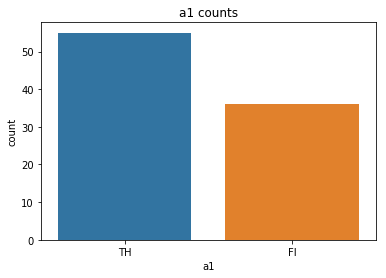

In [4]:
sns.countplot(df.a1)
plt.title('a1 counts')

In [5]:
X = df.a2
Y = df.lowtext
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [8]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [9]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 68 samples, validate on 18 samples
Epoch 1/10
68/68 [==============================] - 1s 21ms/step - loss: 0.9920 - acc: 0.0147 - val_loss: -2.2099 - val_acc: 0.0000e+00
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: -2.2317 - acc: 0.0000e+00 - val_loss: -6.2272 - val_acc: 0.0000e+00
Epoch 3/10
68/68 [==============================] - 0s 3ms/step - loss: -6.5033 - acc: 0.0000e+00 - val_loss: -13.4513 - val_acc: 0.0000e+00
Epoch 4/10
68/68 [==============================] - 0s 2ms/step - loss: -13.2139 - acc: 0.0000e+00 - val_loss: -29.4024 - val_acc: 0.0000e+00
Epoch 5/10
68/68 [==============================] - 0s 2ms/step - loss: -29.0680 - acc: 0.0000e+00 - val_loss: -93.9035 - val_acc: 0.0000e+00
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: -93.6820 - acc: 0.0000e+00 - val_loss: -223.2548 - val_acc: 0.0000e+00
Epoch 7/10
68/68 [==============================] - 0s 3ms/step - loss: -223.2197 - acc: 0.0000e+00 - val_loss: 

In [10]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

16/16 [==============================] - 0s 1ms/step


In [11]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: -472.713
  Accuracy: 0.062
